In [0]:
pip install shap

Python interpreter will be restarted.
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Not uninstalling packaging at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-1d82d26e-90f5-40a6-87de-af4541a723c8
    Can't uninstall 'packaging'. No files were found to uninstall.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1d82d26e-90f5-40a6-87de-af4541a723c8/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
pip install catboost

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1d82d26e-90f5-40a6-87de-af4541a723c8/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
pip install ipywidgets

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1d82d26e-90f5-40a6-87de-af4541a723c8/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

import catboost
print('catboost version:', catboost.__version__)
from catboost import CatBoostClassifier 

catboost version: 1.0.4


In [0]:
titanic_df = pd.read_csv( "file:/tmp/titanic_train.csv")
titanic_df.head()

titanic_df.columns

Out[67]: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [0]:
titanic_df.count()

Out[68]: PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [0]:
# strip first letter from cabin number if there
titanic_df['Cabin'] = titanic_df['Cabin'].replace(np.NaN, 'U') 
titanic_df['Cabin'] = [ln[0] for ln in titanic_df['Cabin'].values]
titanic_df['Cabin'] = titanic_df['Cabin'].replace('U', 'Unknown') 
 
# create isfemale field and use numerical values
titanic_df['isfemale'] = np.where(titanic_df['Sex'] == 'female', 1, 0)

# drop features not needed for model 
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['Sex', 'Name', 'boat','body', 'ticket', 'home.dest' , 'PassengerId']]]

# make pclass actual categorical column
titanic_df['Pclass'] = np.where(titanic_df['Pclass'] == 1, 'First', 
                                np.where(titanic_df['Pclass'] == 2, 'Second', 'Third'))


titanic_df['Embarked'] = titanic_df['Embarked'].replace(np.NaN, 'Unknown') 

# impute age to mean
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())
titanic_df['Age']

titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isfemale
0,0,Third,22.0,1,0,A/5 21171,7.2500,Unknown,S,0
1,1,First,38.0,1,0,PC 17599,71.2833,C,C,1
2,1,Third,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,1
3,1,First,35.0,1,0,113803,53.1000,C,S,1
4,0,Third,35.0,0,0,373450,8.0500,Unknown,S,0


In [0]:
titanic_catboost_ready_df = titanic_df.dropna() 

features = [feat for feat in list(titanic_catboost_ready_df) 
            if feat != 'Survived']
print(features)
categorical_features = np.where(titanic_catboost_ready_df[features].dtypes != np.float)[0]
 

X_train, X_test, y_train, y_test = train_test_split(titanic_df[features], 
                                                    titanic_df[['Survived']], 
                                                    test_size=0.3, 
                                                     random_state=1)
 
params = {'iterations':5000,
        'learning_rate':0.001,
        'cat_features':categorical_features,
        'depth':10,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 1
          }

cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train, y_train,   
          eval_set=(X_test, y_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True  
         );
 


['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'isfemale']
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))0:	test: 0.8179596	best: 0.8179596 (0)	total: 11.8ms	remaining: 58.8s
200:	test: 0.8200341	best: 0.8276215 (5)	total: 3.76s	remaining: 1m 29s
400:	test: 0.8202614	best: 0.8276215 (5)	total: 7.62s	remaining: 1m 27s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8276214834
bestIteration = 5

Shrink model to first 6 iterations.


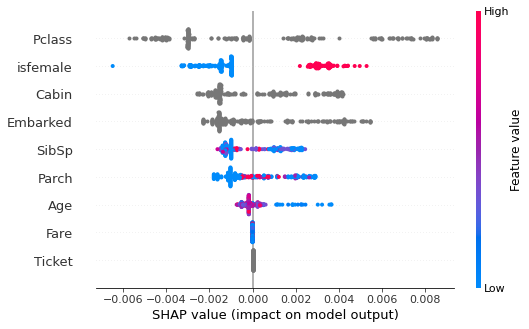

In [0]:
from catboost import CatBoostClassifier, Pool
shap_values = cat_model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features) ,
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])
shap.summary_plot(shap_values, X_test)


In [0]:
predictions = cat_model.predict(X_test)

In [0]:
from sklearn.metrics import classification_report
classification_report(y_test,predictions)

Out[73]: '              precision    recall  f1-score   support\n\n           0       0.73      0.92      0.82       153\n           1       0.84      0.56      0.67       115\n\n    accuracy                           0.76       268\n   macro avg       0.79      0.74      0.74       268\nweighted avg       0.78      0.76      0.75       268\n'

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions)

Out[74]: array([[141,  12],
       [ 51,  64]])

Out[75]: <AxesSubplot:>

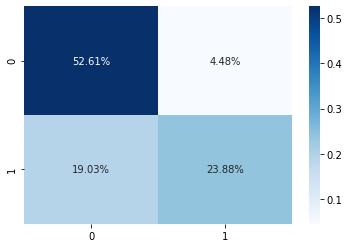

In [0]:
import seaborn as sns
cf_matrix=confusion_matrix(y_test,predictions)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Out[76]: <AxesSubplot:>

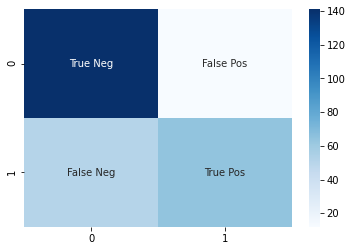

In [0]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

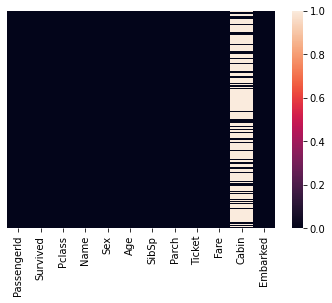

In [0]:
#########creating dataset with different approach to see if outcome confusion matrix works in same way or not 
df = pd.read_csv("/tmp/titanic_train.csv",header = 'infer')
df.head()
df['Age'].fillna((df['Age'].mean()), inplace=True)
sns.heatmap(df.isnull() , yticklabels=False)
df.drop('Cabin' , axis =1 , inplace=True)
df.dropna(inplace=True)
sex = pd.get_dummies(df['Sex'] , drop_first=True)
df.columns
embark = pd.get_dummies(df['Embarked'] , drop_first=True)
df = pd.concat([df , sex,embark] ,axis =1 )
df.drop(['Sex' , 'Embarked' , 'Name' , 'Ticket' , 'PassengerId'] , axis=1 , inplace=True)
from sklearn.model_selection import train_test_split
#X = df [[ 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q','S']]
#y = df [['Survived']]
X=df.drop('Survived' , axis =1 )
y=df['Survived']
X_train, X_test, y_train, y_test = train_test_split(   X, y, test_size=0.4, random_state=101) 

In [0]:
titanic_catboost_ready_df = df.dropna() 

features = [feat for feat in list(titanic_catboost_ready_df) 
            if feat != 'survived']
print(features)
# categorical_features = np.where(titanic_catboost_ready_df[features].dtypes != np.float)[0]

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S']


In [0]:
titanic_catboost_ready_df = df.dropna() 

features = [feat for feat in list(titanic_catboost_ready_df) 
            if feat != 'survived']
print(features)
categorical_features = np.where(titanic_catboost_ready_df[features].dtypes != np.float)[0]
 

X_train, X_test, y_train, y_test = train_test_split(df[features], df[['Survived']], test_size=0.3, random_state=1)

# X_train, X_test, y_train, y_test = train_test_split(   X, y, test_size=0.4, random_state=101) 
 
params = {'iterations':5000,
        'learning_rate':0.001,
        'cat_features':categorical_features,
        'depth':10,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 1
          }

cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train, y_train,   
          eval_set=(X_test, y_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True  
         );
 


['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S']
MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))0:	test: 0.9999105	best: 0.9999105 (0)	total: 5.14ms	remaining: 25.7s
200:	test: 1.0000000	best: 1.0000000 (1)	total: 606ms	remaining: 14.5s
400:	test: 1.0000000	best: 1.0000000 (1)	total: 1.15s	remaining: 13.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1
bestIteration = 1

Shrink model to first 2 iterations.


In [0]:
X_test , y_test , cat_model.predict ( X_test)

Out[19]: (     Survived  Pclass        Age  SibSp  Parch     Fare  male  Q  S
 387         1       2  36.000000      0      0  13.0000     0  0  1
 259         1       2  50.000000      0      1  26.0000     0  0  1
 771         0       3  48.000000      0      0   7.8542     1  0  1
 208         1       3  16.000000      0      0   7.7500     0  1  0
 683         0       3  14.000000      5      2  46.9000     1  0  1
 ..        ...     ...        ...    ...    ...      ...   ... .. ..
 248         1       1  37.000000      1      1  52.5542     1  0  1
 601         0       3  29.699118      0      0   7.8958     1  0  1
 240         0       3  29.699118      1      0  14.4542     0  0  0
 468         0       3  29.699118      0      0   7.7250     1  1  0
 93          0       3  26.000000      1      2  20.5750     1  0  1
 
 [267 rows x 9 columns],
      Survived
 387         1
 259         1
 771         0
 208         1
 683         0
 ..        ...
 248         1
 601         0
 

In [0]:
predictions = cat_model.predict ( X_test)
df_out = X_test.copy()
df_out['Survived']= y_test
df_out.reset_index(inplace=True)
df_out['pred'] = predictions

In [0]:
sparkDf = spark.createDataFrame(df_out);

createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field male. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion from Arrow: uint8
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


In [0]:
display(sparkDf.head(10))

index,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,pred
387,1,2,36.0,0,0,13.0,0,0,1,1
259,1,2,50.0,0,1,26.0,0,0,1,1
771,0,3,48.0,0,0,7.8542,1,0,1,0
208,1,3,16.0,0,0,7.75,0,1,0,1
683,0,3,14.0,5,2,46.9,1,0,1,0
3,1,1,35.0,1,0,53.1,0,0,1,1
677,1,3,18.0,0,0,9.8417,0,0,1,1
542,0,3,11.0,4,2,31.275,0,0,1,0
532,0,3,17.0,1,1,7.2292,1,0,0,0
2,1,3,26.0,0,0,7.925,0,0,1,1


In [0]:
sparkDf.createOrReplaceTempView("out1")

In [0]:
spark.sql("select * from out1 where index = 724").show()

+-----+--------+------+----+-----+-----+----+----+---+---+----+
|index|Survived|Pclass| Age|SibSp|Parch|Fare|male|  Q|  S|pred|
+-----+--------+------+----+-----+-----+----+----+---+---+----+
|  724|       1|     1|27.0|    1|    0|53.1|   1|  0|  1|   1|
+-----+--------+------+----+-----+-----+----+----+---+---+----+



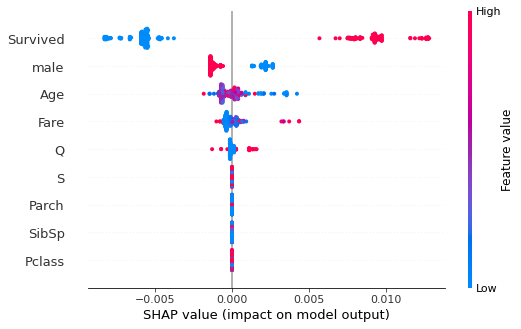

In [0]:
from catboost import CatBoostClassifier, Pool
shap_values = cat_model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features) ,
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])
shap.summary_plot(shap_values, X_test)
